## <center>Give Me Some Credit</center>
#### <center>Improve on the state of the art in credit scoring by predicting the probability that somebody will experience financial distress in the next two years.</center>

__[Kaggle competition](https://www.kaggle.com/c/GiveMeSomeCredit/overview)__

Banks play a crucial role in market economies. They decide who can get finance and on what terms and can make or break investment decisions. For markets and society to function, individuals and companies need access to credit. 

Credit scoring algorithms, which make a guess at the probability of default, are the method banks use to determine whether or not a loan should be granted. This competition requires participants to improve on the state of the art in credit scoring, by predicting the probability that somebody will experience financial distress in the next two years.

The goal of this competition is to build a model that borrowers can use to help make the best financial decisions.

In [1]:
import numpy as np
import pandas as pd

pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 50)
pd.set_option('display.width', 80)

from tqdm import tqdm_notebook as tqdm
import gc
import pickle

from sklearn.metrics import (roc_auc_score, f1_score, confusion_matrix,
                             classification_report, make_scorer)
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score

from scipy.stats import norm

from sklearn.preprocessing import QuantileTransformer

from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold

from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from xgboost import XGBClassifier

from sklearn.model_selection import validation_curve, learning_curve

from hyperopt import hp, tpe
from hyperopt.fmin import fmin
#from hyperopt.pyll import scope as ho_scope

from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

RANDOM_STATE = 17

### Variable Description

* __SeriousDlqin2yrs__ - person experienced 90 days past due delinquency or worse for the last 2 years (1/0)
* __RevolvingUtilizationOfUnsecuredLines__ - total balance on credit cards and personal lines of credit except real estate and no installment debt like car loans divided by the sum of credit limits (%)
* __age__ - age of borrower in years (integer)
* __NumberOfTime30-59DaysPastDueNotWorse__ - number of times borrower has been 30-59 days past due but no worse in the last 2 years (integer)
* __DebtRatio__ - monthly debt payments, alimony, living costs divided by monthy gross income (%)
* __MonthlyIncome__ - monthly income (float)
* __NumberOfOpenCreditLinesAndLoans__ - number of open loans (installment like car loan or mortgage) and lines of credit (e.g. credit cards) (integer)
* __NumberOfTimes90DaysLate__ - number of times borrower has been 90 days or more past due (integer)
* __NumberRealEstateLoansOrLines__ - number of mortgage and real estate loans including home equity lines of credit (integer)
* __NumberOfTime60-89DaysPastDueNotWorse__ - number of times borrower has been 60-89 days past due but no worse in the last 2 years (integer)
* __NumberOfDependents__ - number of dependents in family excluding themselves (spouse, children etc.) (integer)

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
df = pd.read_csv('/content/drive/My Drive/Jupyter Notebooks/data/cs-training.csv', index_col=0)

In [2]:
df = pd.read_csv('data/cs-training.csv', index_col=0)

### EDA & Feature Engineering

In [3]:
df.head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0


In [4]:
df.shape
df.describe(include = "all").T

(150000, 11)

,count,mean,std,min,25%,50%,75%,max
SeriousDlqin2yrs,150000.0,0.066840,0.249746,0.0,0.000000,0.000000,0.000000,1.0
RevolvingUtilizationOfUnsecuredLines,150000.0,6.048438,249.755371,0.0,0.029867,0.154181,0.559046,50708.0
age,150000.0,52.295207,14.771866,0.0,41.000000,52.000000,63.000000,109.0
NumberOfTime30-59DaysPastDueNotWorse,150000.0,0.421033,4.192781,0.0,0.000000,0.000000,0.000000,98.0
DebtRatio,150000.0,353.005076,2037.818523,0.0,0.175074,0.366508,0.868254,329664.0
MonthlyIncome,120269.0,6670.221237,14384.674215,0.0,3400.000000,5400.000000,8249.000000,3008750.0
NumberOfOpenCreditLinesAndLoans,150000.0,8.452760,5.145951,0.0,5.000000,8.000000,11.000000,58.0
NumberOfTimes90DaysLate,150000.0,0.265973,4.169304,0.0,0.000000,0.000000,0.000000,98.0
NumberRealEstateLoansOrLines,150000.0,1.018240,1.129771,0.0,0.000000,1.000000,2.000000,54.0
NumberOfTime60-89DaysPastDueNotWorse,150000.0,0.240387,4.155179,0.0,0.000000,0.000000,0.000000,98.0


In [5]:
df.rename(columns=lambda x: x.replace('-', '_'), inplace=True)
feature_names = df.columns[1:]

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150000 entries, 1 to 150000
Data columns (total 11 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   SeriousDlqin2yrs                      150000 non-null  int64  
 1   RevolvingUtilizationOfUnsecuredLines  150000 non-null  float64
 2   age                                   150000 non-null  int64  
 3   NumberOfTime30_59DaysPastDueNotWorse  150000 non-null  int64  
 4   DebtRatio                             150000 non-null  float64
 5   MonthlyIncome                         120269 non-null  float64
 6   NumberOfOpenCreditLinesAndLoans       150000 non-null  int64  
 7   NumberOfTimes90DaysLate               150000 non-null  int64  
 8   NumberRealEstateLoansOrLines          150000 non-null  int64  
 9   NumberOfTime60_89DaysPastDueNotWorse  150000 non-null  int64  
 10  NumberOfDependents                    146076 non-null  float64
dtype

In [7]:
df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30_59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60_89DaysPastDueNotWorse        0
NumberOfDependents                       3924
dtype: int64

In [8]:
df.SeriousDlqin2yrs.value_counts(normalize=True) * 100

0    93.316
1     6.684
Name: SeriousDlqin2yrs, dtype: float64

#### Visualization

Wall time: 38.6 s


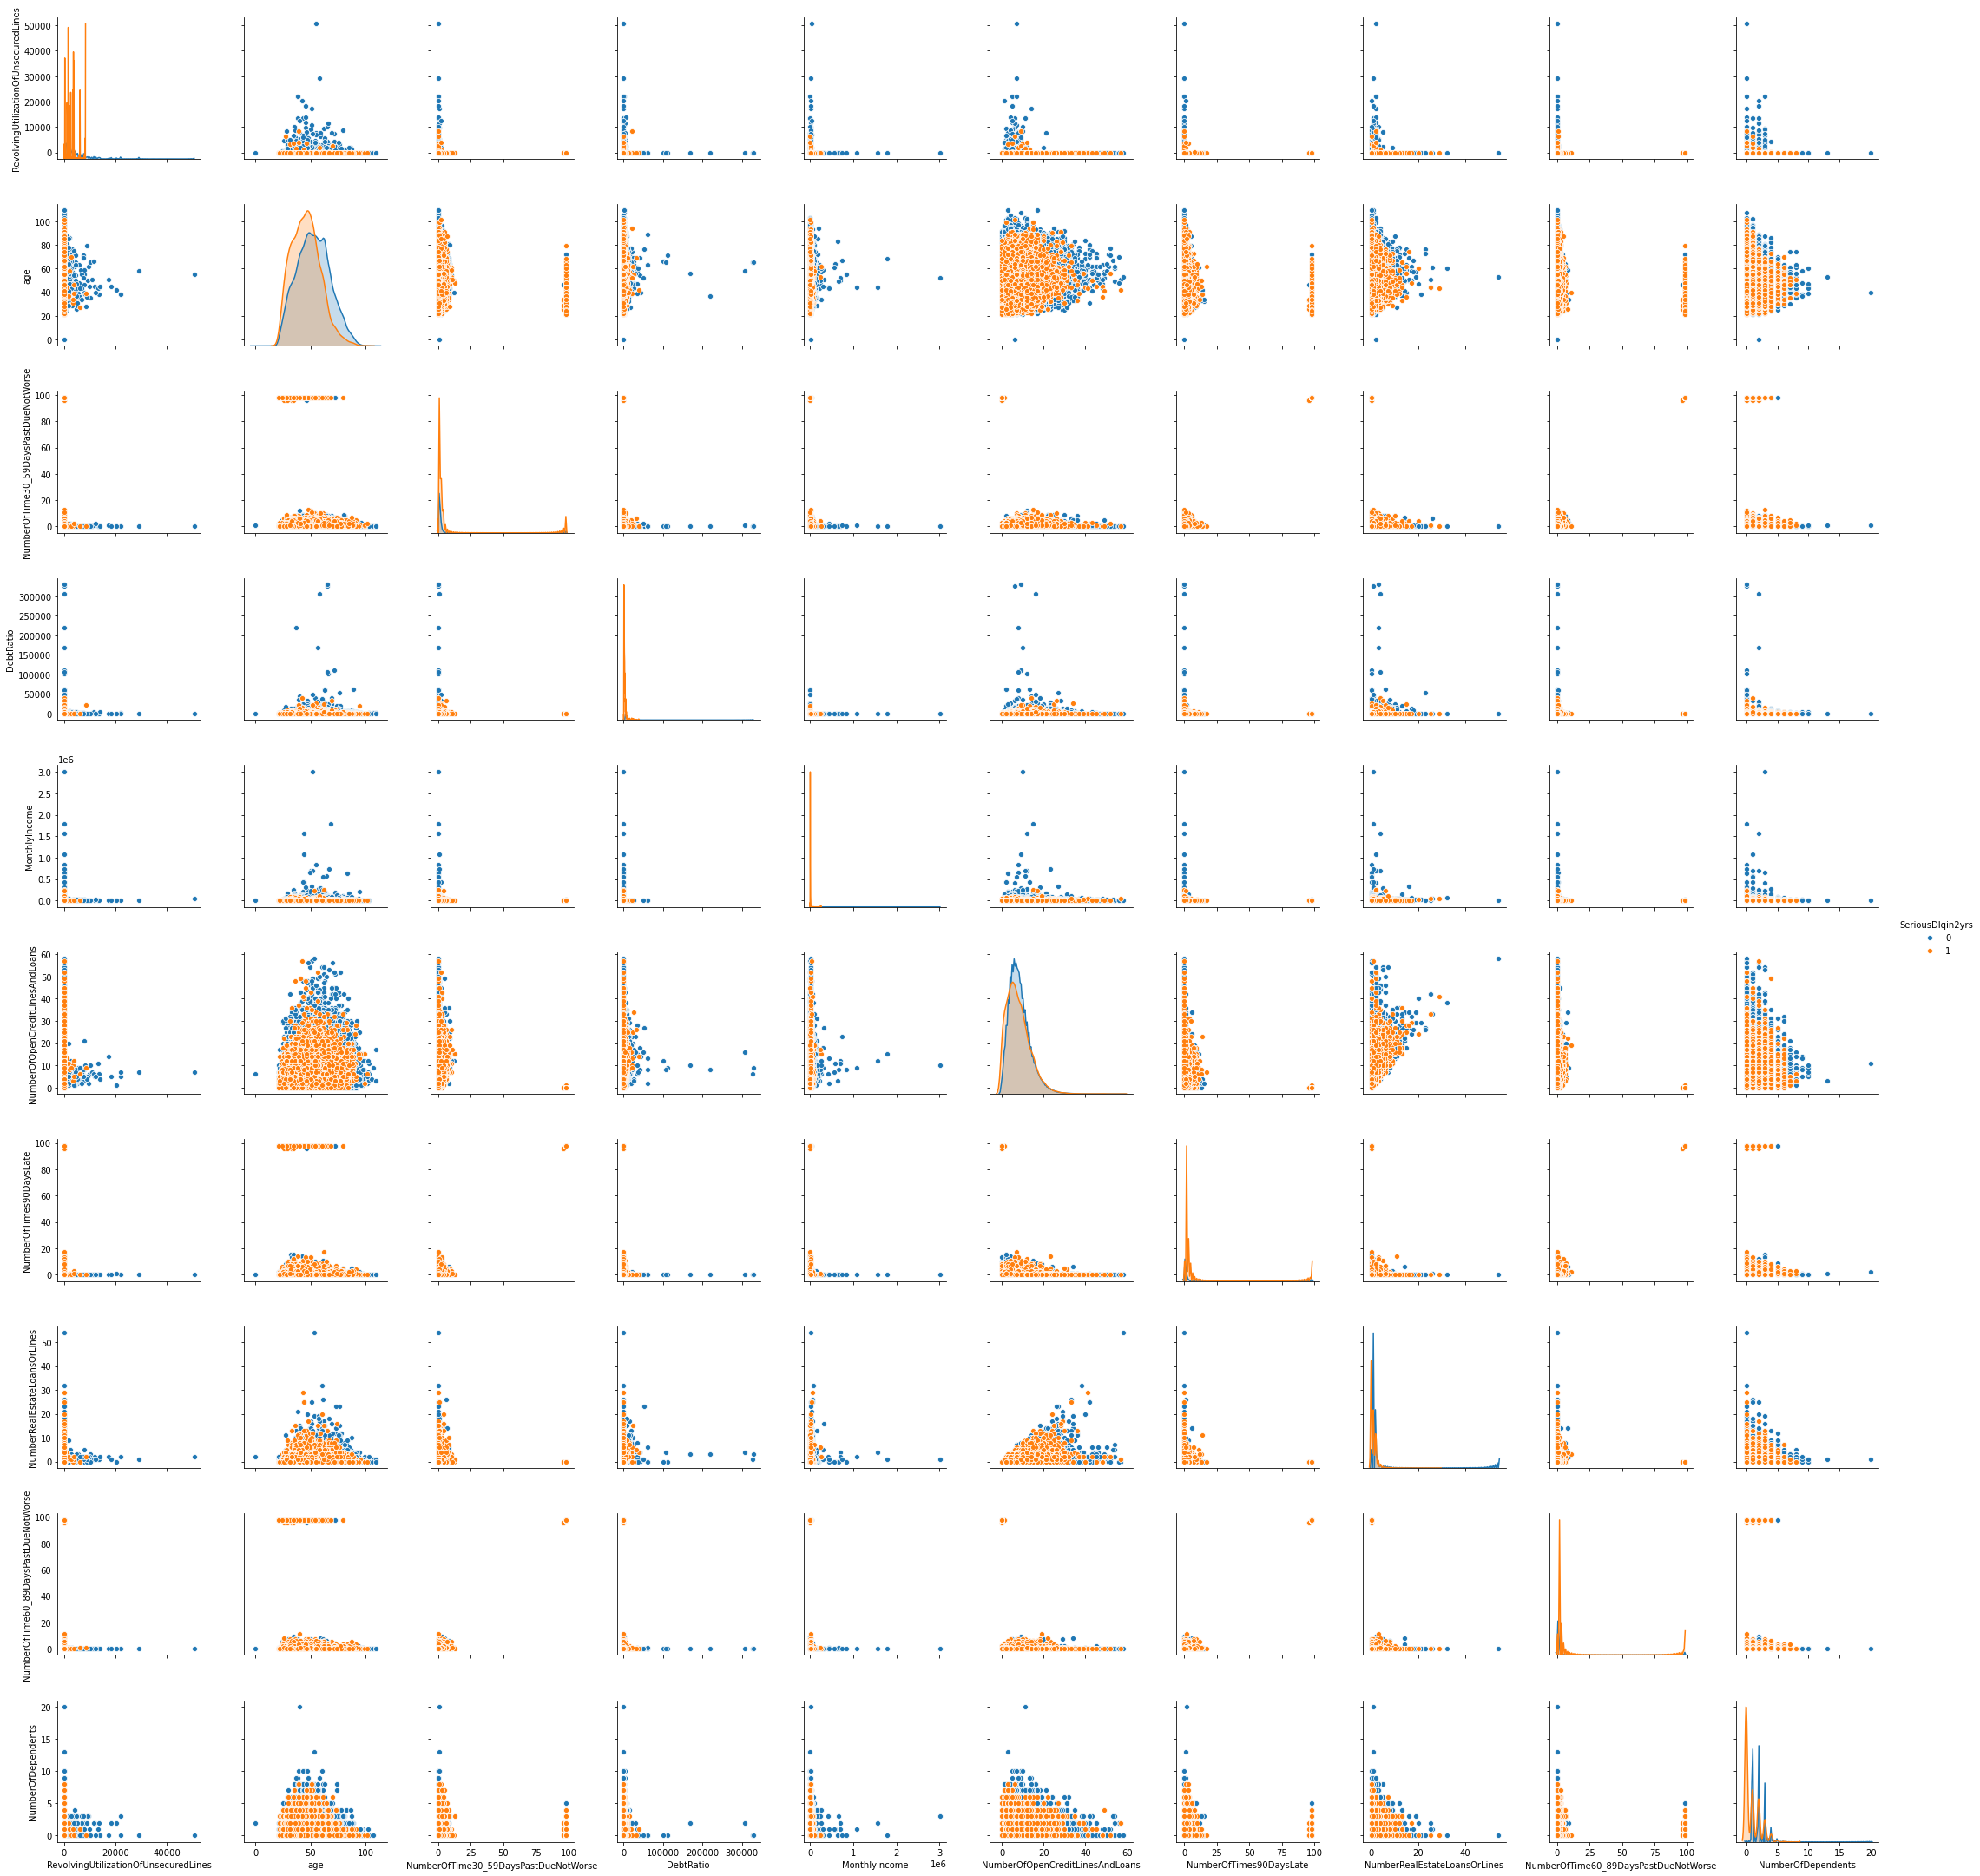

In [ ]:
%%time
sns.pairplot(df, hue="SeriousDlqin2yrs", height=3);

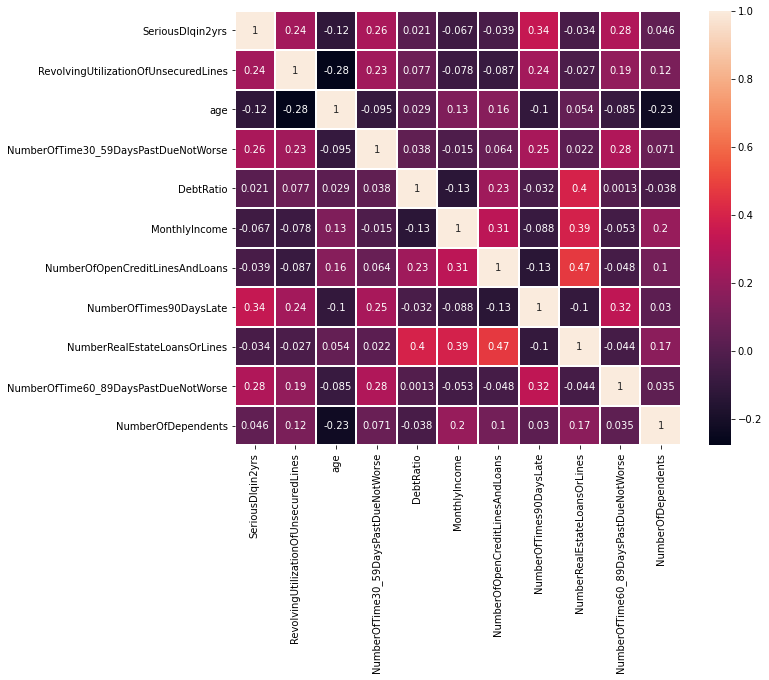

In [ ]:
plt.figure(figsize=(10,8))
corr = df.corr(method='spearman')
sns.heatmap(corr, annot=True, linewidths=1);

__**QQ**__: 

1. Max of `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTimes90DaysLate`, `NumberOfTime60-89DaysPastDueNotWorse` is the same value **98**. It's weird.

2. How `DebtRatio` was calculated in the absence of `MonthlyIncome` values?

3. Max of `RevolvingUtilizationOfUnsecuredLines` and `DebtRatio` are the values **50708.0** and **329664.0** respectively. But the unit of measurement is percentage...

#### 1. `NumberOfTime30-59DaysPastDueNotWorse`, `NumberOfTimes90DaysLate`, `NumberOfTime60-89DaysPastDueNotWorse`

In [9]:
len(df[df.NumberOfTime30_59DaysPastDueNotWorse > 97])
len(df[df.NumberOfTimes90DaysLate > 97])
len(df[df.NumberOfTime60_89DaysPastDueNotWorse > 97])
len(df[(df.NumberOfTimes90DaysLate > 97) & 
       (df.NumberOfTime30_59DaysPastDueNotWorse > 97) & 
       (df.NumberOfTime60_89DaysPastDueNotWorse > 97)])

264

264

264

264

In [10]:
df[df.NumberOfTimes90DaysLate > 97].head()

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents
1734,1,1.0,27,98,0.0,2700.0,0,98,0,98,0.0
2287,0,1.0,22,98,0.0,NaN,0,98,0,98,0.0
3885,0,1.0,38,98,12.0,NaN,0,98,0,98,0.0
4418,0,1.0,21,98,0.0,0.0,0,98,0,98,0.0
4706,0,1.0,21,98,0.0,2000.0,0,98,0,98,0.0


In [11]:
df.NumberOfTime30_59DaysPastDueNotWorse.value_counts().sort_index()

0     126018
1      16033
2       4598
3       1754
4        747
5        342
6        140
7         54
8         25
9         12
10         4
11         1
12         2
13         1
96         5
98       264
Name: NumberOfTime30_59DaysPastDueNotWorse, dtype: int64

In [12]:
df.NumberOfTimes90DaysLate.value_counts().sort_index()

0     141662
1       5243
2       1555
3        667
4        291
5        131
6         80
7         38
8         21
9         19
10         8
11         5
12         2
13         4
14         2
15         2
17         1
96         5
98       264
Name: NumberOfTimes90DaysLate, dtype: int64

In [13]:
df.NumberOfTime60_89DaysPastDueNotWorse.value_counts().sort_index()

0     142396
1       5731
2       1118
3        318
4        105
5         34
6         16
7          9
8          2
9          1
11         1
96         5
98       264
Name: NumberOfTime60_89DaysPastDueNotWorse, dtype: int64

In [14]:
df_higher96 = df[df['NumberOfTimes90DaysLate'] > 95][[
    'NumberOfTime30_59DaysPastDueNotWorse', 'NumberOfTimes90DaysLate',
    'NumberOfTime60_89DaysPastDueNotWorse', 'SeriousDlqin2yrs'
]]
df_higher96.describe()

,NumberOfTime30_59DaysPastDueNotWorse,NumberOfTimes90DaysLate,NumberOfTime60_89DaysPastDueNotWorse,SeriousDlqin2yrs
count,269.000000,269.000000,269.000000,269.000000
mean,97.962825,97.962825,97.962825,0.546468
std,0.270628,0.270628,0.270628,0.498764
min,96.000000,96.000000,96.000000,0.000000
25%,98.000000,98.000000,98.000000,0.000000
50%,98.000000,98.000000,98.000000,1.000000
75%,98.000000,98.000000,98.000000,1.000000
max,98.000000,98.000000,98.000000,1.000000


In [15]:
df_higher96.SeriousDlqin2yrs.value_counts()

1    147
0    122
Name: SeriousDlqin2yrs, dtype: int64

Some new variables:

In [16]:
df['NumberOfTimes_PastDue'] = (df.NumberOfTime30_59DaysPastDueNotWorse + 
                              df.NumberOfTimes90DaysLate + 
                              df.NumberOfTime60_89DaysPastDueNotWorse)

In [17]:
# High
df['NumberOfTimesLate_high'] = np.where(
    df.NumberOfTime30_59DaysPastDueNotWorse > 95, 1, 0).astype('object')

# 96
df['NumberOfTimesLate_96'] = np.where(
    df.NumberOfTime30_59DaysPastDueNotWorse == 96, 1, 0).astype('object')

# 98
df['NumberOfTimesLate_98'] = np.where(
    df.NumberOfTime30_59DaysPastDueNotWorse == 98, 1, 0).astype('object')

# 0
df['NumberOfTime30_59Days_none'] = np.where(
    df.NumberOfTime30_59DaysPastDueNotWorse == 0, 1, 0).astype('object')
df['NumberOfTimes90Days_none'] = np.where(df.NumberOfTimes90DaysLate == 0, 1,
                                          0).astype('object')
df['NumberOfTime60_89Days_none'] = np.where(
    df.NumberOfTime60_89DaysPastDueNotWorse == 0, 1, 0).astype('object')

In [18]:
# Replace values 96 and 98 with 20
df.NumberOfTime30_59DaysPastDueNotWorse[
    df.NumberOfTime30_59DaysPastDueNotWorse > 95] = 20
df.NumberOfTimes90DaysLate[
    df.NumberOfTime30_59DaysPastDueNotWorse > 95] = 20
df.NumberOfTime60_89DaysPastDueNotWorse[
    df.NumberOfTime60_89DaysPastDueNotWorse > 95] = 20

#### 2. `DebtRatio` и `MonthlyIncome`

In [19]:
df.DebtRatio.value_counts().sort_index()

0.000000         4113
0.000026            1
0.000037            1
0.000039            1
0.000066            1
                 ... 
168835.000000       1
220516.000000       1
307001.000000       1
326442.000000       1
329664.000000       1
Name: DebtRatio, Length: 114194, dtype: int64

In [20]:
df.DebtRatio[df.MonthlyIncome.isna()].value_counts().sort_index()

0.0         1622
1.0          205
2.0          160
3.0          155
4.0          162
            ... 
168835.0       1
220516.0       1
307001.0       1
326442.0       1
329664.0       1
Name: DebtRatio, Length: 5728, dtype: int64

When missing values `MonthlyIncome` value` DebtRatio` zero or greater than 1.
Let's create an intermediate variable `MonthlyIncomeFilled`. 

In [21]:
df['MonthlyIncomeFilled'] = df.MonthlyIncome
df.MonthlyIncomeFilled.fillna(1, inplace=True)

Create feature `MonthlyPayment` - **'monthly debt payments, alimony, living costs'** (the numerator of `DebtRatio`).

In [22]:
df['MonthlyPayment'] = df.DebtRatio * df.MonthlyIncomeFilled

In [23]:
df[['DebtRatio', 'MonthlyPayment', 'MonthlyIncomeFilled']]

,DebtRatio,MonthlyPayment,MonthlyIncomeFilled
1,0.802982,7323.197016,9120.0
2,0.121876,316.878123,2600.0
3,0.085113,258.914887,3042.0
4,0.036050,118.963951,3300.0
5,0.024926,1584.975094,63588.0
...,...,...,...
149996,0.225131,472.774869,2100.0
149997,0.716562,4001.283436,5584.0
149998,3870.000000,3870.000000,1.0
149999,0.000000,0.000000,5716.0


In [24]:
len(df[df['MonthlyPayment']==0.0])

5650

In [25]:
df['MonthlyPayment'].describe()

count    150000.000000
mean       2029.675384
std        4210.622764
min           0.000000
25%         510.744628
50%        1528.901456
75%        2787.698312
max      478450.559160
Name: MonthlyPayment, dtype: float64

We assume that if `MonthlyPayment` value is **0**, then, according to the formula, `DebtRatio` value is **0** too. If `MonthlyIncome` value is missing then `DebtRatio` value is equal `MonthlyPayment` value.

In [26]:
df = df.drop('MonthlyIncomeFilled', axis=1)

In [27]:
# Some new features
df['MonthlyIncome_none'] = np.where(df.MonthlyIncome.isna(), 1,
                                    0).astype('object')
df['MonthlyIncome_zero'] = np.where(df.MonthlyIncome == 0.0, 1,
                                    0).astype('object')
df['DebtRatio_zero'] = np.where(df.DebtRatio == 0.0, 1, 0).astype('object')

In [28]:
df.DebtRatio[df.DebtRatio > 1.0] = 0.0

#### 3. `RevolvingUtilizationOfUnsecuredLines`

In [29]:
df.RevolvingUtilizationOfUnsecuredLines.value_counts()

0.000000    10878
1.000000    10256
1.000000       17
0.950100        8
0.713147        6
            ...  
0.486200        1
0.039377        1
0.030780        1
0.355181        1
0.168611        1
Name: RevolvingUtilizationOfUnsecuredLines, Length: 125728, dtype: int64

In [30]:
# RevolvingUtilizationOfUnsecuredLines values higher than mean value:
df.RevolvingUtilizationOfUnsecuredLines[
    df.RevolvingUtilizationOfUnsecuredLines > 6.048438].value_counts().sort_index()

# and how many
len(df.RevolvingUtilizationOfUnsecuredLines[
    df.RevolvingUtilizationOfUnsecuredLines > 6.048438])

6.425716        1
6.478840        1
7.308970        1
8.599600        1
8.851852        1
               ..
20514.000000    1
22000.000000    1
22198.000000    1
29110.000000    1
50708.000000    1
Name: RevolvingUtilizationOfUnsecuredLines, Length: 243, dtype: int64

246

In [31]:
df[df.RevolvingUtilizationOfUnsecuredLines > 1].SeriousDlqin2yrs.describe()

count    3321.000000
mean        0.372478
std         0.483538
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max         1.000000
Name: SeriousDlqin2yrs, dtype: float64

The correlation of variables `RevolvingUtilizationOfUnsecuredLines` and `SeriousDlqin2yrs` is quite high.

Some new features:

In [32]:
df['RUUL_high'] = np.where(
    df.RevolvingUtilizationOfUnsecuredLines > 1, 1, 0).astype('object')
df['RUUL_zero'] = np.where(
    df.RevolvingUtilizationOfUnsecuredLines == 0, 1, 0).astype('object')
df['RUUL_ones'] = np.where(
    df.RevolvingUtilizationOfUnsecuredLines == 1, 1, 0).astype('object')

In [33]:
df.head()
df.shape

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents,NumberOfTimes_PastDue,NumberOfTimesLate_high,NumberOfTimesLate_96,NumberOfTimesLate_98,NumberOfTime30_59Days_none,NumberOfTimes90Days_none,NumberOfTime60_89Days_none,MonthlyPayment,MonthlyIncome_none,MonthlyIncome_zero,DebtRatio_zero,RUUL_high,RUUL_zero,RUUL_ones
1,1,0.766127,45,2,0.802982,9120.0,13,0,6,0,2.0,2,0,0,0,0,1,1,7323.197016,0,0,0,0,0,0
2,0,0.957151,40,0,0.121876,2600.0,4,0,0,0,1.0,0,0,0,0,1,1,1,316.878123,0,0,0,0,0,0
3,0,0.658180,38,1,0.085113,3042.0,2,1,0,0,0.0,2,0,0,0,0,0,1,258.914887,0,0,0,0,0,0
4,0,0.233810,30,0,0.036050,3300.0,5,0,0,0,0.0,0,0,0,0,1,1,1,118.963951,0,0,0,0,0,0
5,0,0.907239,49,1,0.024926,63588.0,7,0,1,0,0.0,1,0,0,0,0,1,1,1584.975094,0,0,0,0,0,0


(150000, 25)

**Fill missing values**

In [34]:
df.isnull().sum()

SeriousDlqin2yrs                            0
RevolvingUtilizationOfUnsecuredLines        0
age                                         0
NumberOfTime30_59DaysPastDueNotWorse        0
DebtRatio                                   0
MonthlyIncome                           29731
NumberOfOpenCreditLinesAndLoans             0
NumberOfTimes90DaysLate                     0
NumberRealEstateLoansOrLines                0
NumberOfTime60_89DaysPastDueNotWorse        0
NumberOfDependents                       3924
NumberOfTimes_PastDue                       0
NumberOfTimesLate_high                      0
NumberOfTimesLate_96                        0
NumberOfTimesLate_98                        0
NumberOfTime30_59Days_none                  0
NumberOfTimes90Days_none                    0
NumberOfTime60_89Days_none                  0
MonthlyPayment                              0
MonthlyIncome_none                          0
MonthlyIncome_zero                          0
DebtRatio_zero                    

In [35]:
# check zero values
(df == 0).sum(axis=0)

SeriousDlqin2yrs                        139974
RevolvingUtilizationOfUnsecuredLines     10878
age                                          1
NumberOfTime30_59DaysPastDueNotWorse    126018
DebtRatio                                39250
MonthlyIncome                             1634
NumberOfOpenCreditLinesAndLoans           1888
NumberOfTimes90DaysLate                 141662
NumberRealEstateLoansOrLines             56188
NumberOfTime60_89DaysPastDueNotWorse    142396
NumberOfDependents                       86902
NumberOfTimes_PastDue                   119637
NumberOfTimesLate_high                  149731
NumberOfTimesLate_96                    149995
NumberOfTimesLate_98                    149736
NumberOfTime30_59Days_none               23982
NumberOfTimes90Days_none                  8338
NumberOfTime60_89Days_none                7604
MonthlyPayment                            5650
MonthlyIncome_none                      120269
MonthlyIncome_zero                      148366
DebtRatio_zer

In [36]:
df[df.age==0]

,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents,NumberOfTimes_PastDue,NumberOfTimesLate_high,NumberOfTimesLate_96,NumberOfTimesLate_98,NumberOfTime30_59Days_none,NumberOfTimes90Days_none,NumberOfTime60_89Days_none,MonthlyPayment,MonthlyIncome_none,MonthlyIncome_zero,DebtRatio_zero,RUUL_high,RUUL_zero,RUUL_ones
65696,0,1.0,0,1,0.436927,6000.0,6,0,2,0,2.0,1,0,0,0,0,1,1,2621.563074,0,0,0,0,0,0


In [37]:
# Replace 'age' zero value with mode:
rep_age = df.age.mode()
df.age[df.age==0] = int(rep_age)

In [38]:
df.NumberOfDependents.mode()
df.NumberOfDependents.median()

0    0.0
dtype: float64

0.0

In [39]:
df['NumberOfDependents_none'] = np.where(
    df.NumberOfDependents.isna(), 1, 0).astype('object')

In [40]:
# Replace 'NumberOfDependents' missing values with 0 (mode and median) 
df.NumberOfDependents.fillna(0, inplace=True)

In [41]:
gc.collect()

80

Let's use `RandomForestRegressor`to fill `MonthlyIncome` missing values. 

In [42]:
split = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
for train_index, valid_index in split.split(df, df.SeriousDlqin2yrs):
    X_train = df.iloc[train_index]    
    X_valid = df.iloc[valid_index]    

In [43]:
X_tr = X_train.drop('SeriousDlqin2yrs', axis=1)
y_tr = X_train.SeriousDlqin2yrs

X_val = X_valid.drop('SeriousDlqin2yrs', axis=1)
y_val = X_valid.SeriousDlqin2yrs

In [44]:
# Just checking
y_tr.value_counts(normalize=True) * 100
y_val.value_counts(normalize=True) * 100

0    93.31619
1     6.68381
Name: SeriousDlqin2yrs, dtype: float64

0    93.315556
1     6.684444
Name: SeriousDlqin2yrs, dtype: float64

In [45]:
X_tr.info()
X_tr.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105000 entries, 138986 to 80531
Data columns (total 25 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   RevolvingUtilizationOfUnsecuredLines  105000 non-null  float64
 1   age                                   105000 non-null  int64  
 2   NumberOfTime30_59DaysPastDueNotWorse  105000 non-null  int64  
 3   DebtRatio                             105000 non-null  float64
 4   MonthlyIncome                         84277 non-null   float64
 5   NumberOfOpenCreditLinesAndLoans       105000 non-null  int64  
 6   NumberOfTimes90DaysLate               105000 non-null  int64  
 7   NumberRealEstateLoansOrLines          105000 non-null  int64  
 8   NumberOfTime60_89DaysPastDueNotWorse  105000 non-null  int64  
 9   NumberOfDependents                    105000 non-null  float64
 10  NumberOfTimes_PastDue                 105000 non-null  int64  
 

(105000, 25)

In [46]:
list(feature_names).index('MonthlyIncome')

4

In [47]:
choose_cols = list(feature_names)
del choose_cols[4]

In [48]:
def fill_miss(data):
    data_miss = data.dropna()
    X_miss = data_miss[choose_cols]
    y_miss = data_miss.MonthlyIncome
    rf_fill = RandomForestRegressor(n_estimators=200).fit(X_miss, y_miss)
    
    X_fill_miss = data[data.MonthlyIncome.isna()]
    X_fill = rf_fill.predict(X_fill_miss[choose_cols])
    data.loc[data.MonthlyIncome.isna(), 'MonthlyIncome'] = X_fill
    
    return data

In [49]:
%%time
df_train = fill_miss(X_tr)

Wall time: 51 s


In [50]:
%%time
df_valid = fill_miss(X_val)

Wall time: 20 s


In [51]:
print(df_train.isna().sum().sum())
print(df_valid.isna().sum().sum())

0
0


In [ ]:
with open('data/df_train.pkl', 'wb') as file:  
    pickle.dump(df_train, file)
with open('data/df_valid.pkl', 'wb') as file:  
    pickle.dump(df_valid, file)

In [52]:
(df_train == 0).sum(axis=0)
(df_valid == 0).sum(axis=0)

RevolvingUtilizationOfUnsecuredLines      7688
age                                          0
NumberOfTime30_59DaysPastDueNotWorse     88178
DebtRatio                                27407
MonthlyIncome                             1146
NumberOfOpenCreditLinesAndLoans           1321
NumberOfTimes90DaysLate                  99103
NumberRealEstateLoansOrLines             39193
NumberOfTime60_89DaysPastDueNotWorse     99662
NumberOfDependents                       63503
NumberOfTimes_PastDue                    83730
NumberOfTimesLate_high                  104818
NumberOfTimesLate_96                    104999
NumberOfTimesLate_98                    104819
NumberOfTime30_59Days_none               16822
NumberOfTimes90Days_none                  5897
NumberOfTime60_89Days_none                5338
MonthlyPayment                            3986
MonthlyIncome_none                       84277
MonthlyIncome_zero                      103854
DebtRatio_zero                          102092
RUUL_high    

RevolvingUtilizationOfUnsecuredLines     3190
age                                         0
NumberOfTime30_59DaysPastDueNotWorse    37840
DebtRatio                               11843
MonthlyIncome                             490
NumberOfOpenCreditLinesAndLoans           567
NumberOfTimes90DaysLate                 42559
NumberRealEstateLoansOrLines            16995
NumberOfTime60_89DaysPastDueNotWorse    42734
NumberOfDependents                      27323
NumberOfTimes_PastDue                   35907
NumberOfTimesLate_high                  44913
NumberOfTimesLate_96                    44996
NumberOfTimesLate_98                    44917
NumberOfTime30_59Days_none               7160
NumberOfTimes90Days_none                 2441
NumberOfTime60_89Days_none               2266
MonthlyPayment                           1664
MonthlyIncome_none                      35992
MonthlyIncome_zero                      44512
DebtRatio_zero                          43795
RUUL_high                         

In [53]:
df_train.shape
df_valid.shape

(105000, 25)

(45000, 25)

__Variables Distribution__

In [54]:
col = df_valid.columns[:10]

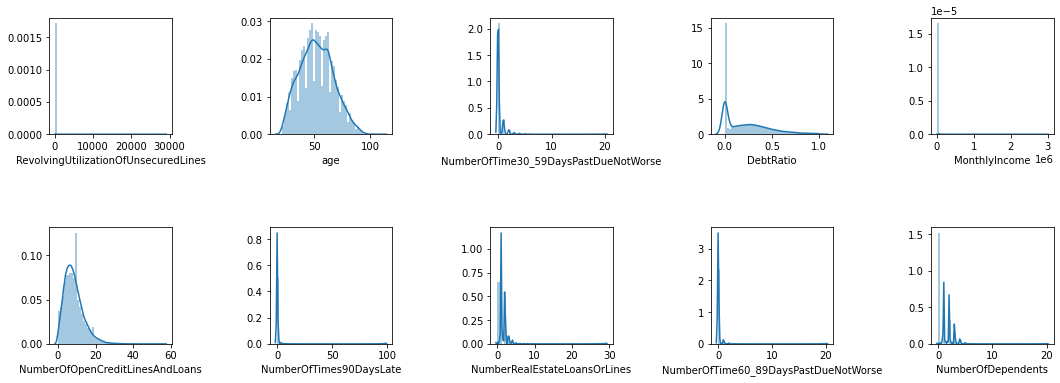

In [55]:
fig , ax = plt.subplots(2,5,figsize=(18,6))
fig.subplots_adjust(hspace=0.8, wspace=0.8)
k=0;
for i in col:
    axes = sns.distplot(df_valid[i], ax=ax[k//5,k%5])
    axes.set(xlabel=i)
    k += 1
pass;

In [56]:
cat_columns = [i for i in df_train.columns if 
               df_train[i].dtype.name=='category' or 
               df_train[i].dtype.name=='object']
num_columns = [i for i in df_train.columns if 
               df_train[i].dtype.name=='float64' or 
               df_train[i].dtype.name=='int64']

In [57]:
df_train_num = df_train[num_columns]

In [58]:
qtf = QuantileTransformer(output_distribution='normal')
qtf.fit(df_train_num)

QuantileTransformer(copy=True, ignore_implicit_zeros=False, n_quantiles=1000,
                    output_distribution='normal', random_state=None,
                    subsample=100000)

In [59]:
def preproc(data, trans):
    data_cat = pd.get_dummies(data[cat_columns])
    data_norm = data[num_columns]
    data_norm[num_columns] = trans.transform(data[num_columns])
    data_all = pd.concat((data_norm, data_cat), axis=1)
    return data_all    

In [60]:
X_train_qt = preproc(df_train, qtf)
X_valid_qt = preproc(df_valid, qtf)

In [61]:
X_train_qt.shape
X_train_qt.head()

(105000, 38)

,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30_59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60_89DaysPastDueNotWorse,NumberOfDependents,NumberOfTimes_PastDue,MonthlyPayment,NumberOfTimesLate_high_0,NumberOfTimesLate_high_1,NumberOfTimesLate_96_0,NumberOfTimesLate_96_1,NumberOfTimesLate_98_0,NumberOfTimesLate_98_1,NumberOfTime30_59Days_none_0,NumberOfTime30_59Days_none_1,NumberOfTimes90Days_none_0,NumberOfTimes90Days_none_1,NumberOfTime60_89Days_none_0,NumberOfTime60_89Days_none_1,MonthlyIncome_none_0,MonthlyIncome_none_1,MonthlyIncome_zero_0,MonthlyIncome_zero_1,DebtRatio_zero_0,DebtRatio_zero_1,RUUL_high_0,RUUL_high_1,RUUL_zero_0,RUUL_zero_1,RUUL_ones_0,RUUL_ones_1,NumberOfDependents_none_0,NumberOfDependents_none_1
138986,-5.199338,-0.176553,-5.199338,-0.187252,0.182449,-0.622621,-5.199338,-5.199338,-5.199338,-5.199338,-5.199338,-0.553162,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0,0,1,1,0,1,0
63965,-0.632635,-0.965420,-5.199338,0.817066,-0.520661,-0.895780,-5.199338,0.120731,-5.199338,0.503497,-5.199338,-0.209569,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0
46078,-1.095772,-0.830234,-5.199338,1.612074,-0.346817,0.642543,-5.199338,0.120731,-5.199338,-5.199338,-5.199338,0.418843,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0
83031,0.692524,0.311059,-5.199338,0.457079,1.819017,1.116369,-5.199338,2.119668,-5.199338,-5.199338,-5.199338,1.464940,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0
11185,0.750720,-1.100140,-5.199338,1.178971,0.492137,0.278302,-5.199338,1.689670,-5.199338,0.503497,-5.199338,0.980895,1,0,1,0,1,0,0,1,0,1,0,1,1,0,1,0,1,0,1,0,1,0,1,0,1,0


In [10]:
with open('data/X_train_qt.pkl', 'wb') as file:  
    pickle.dump(X_train_qt, file)
with open('data/X_valid_qt.pkl', 'wb') as file:  
    pickle.dump(X_valid_qt, file)

### Modeling

In [62]:
skf5 = StratifiedKFold(n_splits=5, shuffle=True, random_state=20)

In [63]:
skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

In [64]:
ftwo_scorer = make_scorer(roc_auc_score, needs_proba=True)

**RandomForestClassifier**

In [ ]:
%%time
def hyperopt_forest_score(params):
    clf = RandomForestClassifier(
        **params,
        random_state=42,
        class_weight='balanced_subsample',
        max_features=X_train_qt.shape[1],
        n_jobs=-1)
    
    current_score = cross_val_score(
        clf, X_train_qt, y_tr, scoring=ftwo_scorer, cv=skf).mean()
    
    print(current_score, params)
    return -current_score

space_forest = {
    'max_depth': hp.choice('max_depth', range(3, 10)),
    'n_estimators': ho_scope.int(hp.quniform('n_estimators', 
                                             150, 1200, 2))
}

best = fmin(
    fn=hyperopt_forest_score,
    space=space_forest,
    algo=tpe.suggest,
    max_evals=30)
print('best:')
print(best)

0.8607437131543147                                                             
{'max_depth': 6, 'n_estimators': 632}                                          
0.8577760751203604                                                             
{'max_depth': 4, 'n_estimators': 692}                                          
0.8597153612190193                                                             
{'max_depth': 8, 'n_estimators': 776}                                          
0.8607436602752788                                                             
{'max_depth': 6, 'n_estimators': 1048}                                         
0.860737414813341                                                              
{'max_depth': 6, 'n_estimators': 1088}                                         
0.8577244710177355                                                             
{'max_depth': 4, 'n_estimators': 290}                                          
0.860682905270534                       

In [87]:
%%time
rf_par = RandomForestClassifier(class_weight='balanced_subsample', 
                                max_depth=6, criterion='entropy', 
                                max_features=X_train_qt.shape[1], 
                                n_estimators=1030, n_jobs=-1, 
                                random_state=2020)
rf_par.fit(X_train_qt, y_tr)

CPU times: user 11min 8s, sys: 1.35 s, total: 11min 9s
Wall time: 2min 57s


In [88]:
%%time
scores_rf_par5 = cross_val_score(rf_par, X_train_qt, y_tr, 
                                scoring='roc_auc', cv=skf5)
print("Cross-validation: {}".format(scores_rf_par5))

Cross-validation: [0.8598257  0.86260472 0.85945559 0.86226945 0.86088736]
CPU times: user 30.3 s, sys: 2.74 s, total: 33 s
Wall time: 11min 23s


In [89]:
scores_rf_par5.mean()

0.8610085637039238

**XGBClassifier**

In [98]:
xgb_par = XGBClassifier(subsample=0.6,
                        reg_lambda=0,
                        reg_alpha=0,
                        n_estimators=550,
                        min_child_weight=6,
                        max_depth=8,
                        learning_rate=0.007,
                        gamma=0.4,
                        colsample_bytree=0.6,
                        max_delta_step=2.0,
                        random_state=0)
xgb_par.fit(X_train_qt, y_tr)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.6, gamma=0.4,
              learning_rate=0.007, max_delta_step=2.0, max_depth=8,
              min_child_weight=6, missing=None, n_estimators=550, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=0, scale_pos_weight=1, seed=None,
              silent=None, subsample=0.6, verbosity=1)

In [99]:
%%time
scores_xgb_par = cross_val_score(xgb_par, X_train_qt, y_tr, 
                                scoring='roc_auc', cv=skf5)
print("Cross-validation: {}".format(scores_xgb_par))

Cross-validation: [0.8653286  0.86603103 0.86134904 0.86749642 0.86555212]
CPU times: user 8min 46s, sys: 627 ms, total: 8min 47s
Wall time: 8min 47s


In [100]:
scores_xgb_par.mean()

0.8651514410596489

### Validation

**RandomForestClassifier**

In [134]:
print(roc_auc_score(y_val, rf_par.predict_proba(X_valid_qt)[:,1]))

0.8629930349575197


In [118]:
y_pred = rf_par.predict_proba(X_valid_qt)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.535372


In [119]:
y_res = [1 if x > best_thresh else 0 for x in y_pred]

In [120]:
print(classification_report(y_res, y_val))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89     35108
           1       0.75      0.23      0.35      9892

    accuracy                           0.81     45000
   macro avg       0.79      0.60      0.62     45000
weighted avg       0.80      0.81      0.77     45000



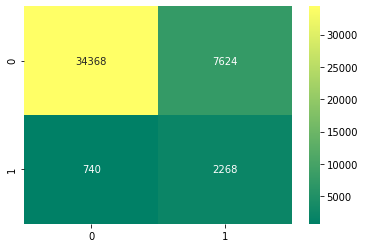

In [121]:
sns.heatmap(confusion_matrix(y_val, y_res), annot=True,
            fmt='3.0f', cmap="summer");

**XGBClassifier**

In [122]:
print(roc_auc_score(y_val, xgb_par.predict_proba(X_valid_qt)[:,1]))

0.866902629851228


In [136]:
y_pred_xgb = xgb_par.predict_proba(X_valid_qt)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val, y_pred_xgb)
J = tpr - fpr
ix = np.argmax(J)
best_thresh = thresholds[ix]
print('Best Threshold=%f' % (best_thresh))

Best Threshold=0.079509


In [137]:
y_res_thresh = [1 if x > best_thresh else 0 for x in y_pred_xgb]

In [138]:
print(classification_report(y_res_thresh, y_val))

              precision    recall  f1-score   support

           0       0.82      0.98      0.89     35063
           1       0.76      0.23      0.35      9937

    accuracy                           0.81     45000
   macro avg       0.79      0.61      0.62     45000
weighted avg       0.81      0.81      0.77     45000



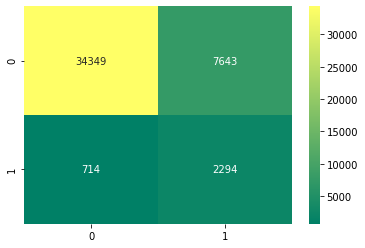

In [139]:
sns.heatmap(confusion_matrix(y_val, y_res_thresh), annot=True,
            fmt='3.0f', cmap="summer");

In [143]:
with open('models/rf_res.pkl', 'wb') as file:  
    pickle.dump(rf_par, file)
with open('models/logit_res.pkl', 'wb') as file:  
    pickle.dump(xgb_par, file)

__Learning Curve__

In [133]:
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):    
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("AUC")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes,
        scoring='roc_auc')
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Cross-validation score")

    plt.legend(loc="best")
    
    return plt

CPU times: user 1.21 s, sys: 514 ms, total: 1.72 s
Wall time: 33min 36s


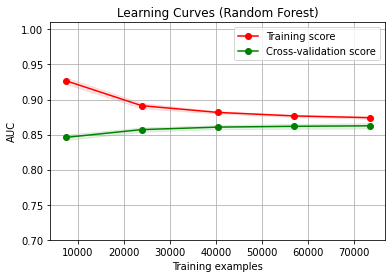

In [135]:
%%time
title = "Learning Curves (Random Forest)"
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.3, random_state=0)

estimator = RandomForestClassifier(class_weight='balanced_subsample', 
                                   max_depth=6, criterion='entropy', 
                                   max_features=X_train_qt.shape[1], 
                                   n_estimators=1164, n_jobs=-1, 
                                   random_state=2020)
plot_learning_curve(estimator, title, X_train_qt, y_tr, 
                    ylim=(0.7, 1.01), cv=cv, n_jobs=-1);